# Calibration of the standard consumption-Saving model

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Calibration of aggregate wealth](#toc2_)    
- 3. [Het-$\beta$ model](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Content:** Solves and simulates a simple consumption-saving model.

**Calibration:** Low and high liquid wealth calibrations.

**Model extension:** Discount factor heterogeneity

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

import scipy.optimize as opt
from ConSavModel import ConSavModelClass

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [15]:
model = ConSavModelClass()

## 2. <a id='toc2_'></a>[Calibration of aggregate wealth](#toc0_)

In [17]:
def calibrate_agg_wealth(x, model, wealth_to_income_target):
    
    # a. guess on beta 
    model.par.beta = x 
    model.par.beta_grid[:] = model.par.beta

    # b. solve
    model.solve(do_print=False)

    # c. simulate
    model.simulate(do_print=False)

    # d. aggregate 
    A = np.sum(model.sim.D*model.sol.a)
   
    return wealth_to_income_target - A/model.par.w 


Calibrate model with high level of liquidity 

In [18]:
# Wealth target 
target_high_wealth = 4.1 * 4

# root finder (scipy) which finds the root of calibrate_agg_wealth() 
sol = opt.root_scalar(calibrate_agg_wealth, bracket=[0.95, 0.989], method='brentq', args=(model, target_high_wealth))

MPCs 

In [20]:
def get_mpcs(model, do_print=False):
    c = model.sol.c 
    a = model.sol.a  
    par = model.par
    a_grid = par.a_grid 

    # calculate mpc 
    mpc = np.zeros_like(c)
    post_return = (1 + par.r) * a_grid

    # Calculate mpc for the inner part of the array
    mpc[:,:, 1:] = np.diff(c, axis=2) / np.diff(post_return)

    # Handle boundary cases (first and last columns)
    mpc[:,:, 0] = (c[:,:, 1] - c[:,:, 0]) / (post_return[1] - post_return[0])
    mpc[:,:, -1] = (c[:,:, -1] - c[:,:, -2]) / (post_return[-1] - post_return[-2])

    # Set MPC to 1 if constrained 
    mpc[a == a_grid[0]] = 1

    MPC = np.sum(mpc*model.sim.D)
    if do_print: print(f'mean MPC: {MPC:6.3f}')

    return mpc, MPC

_,_=get_mpcs(model, do_print=True)

mean MPC:  0.085


Plot MPCs and distribution 

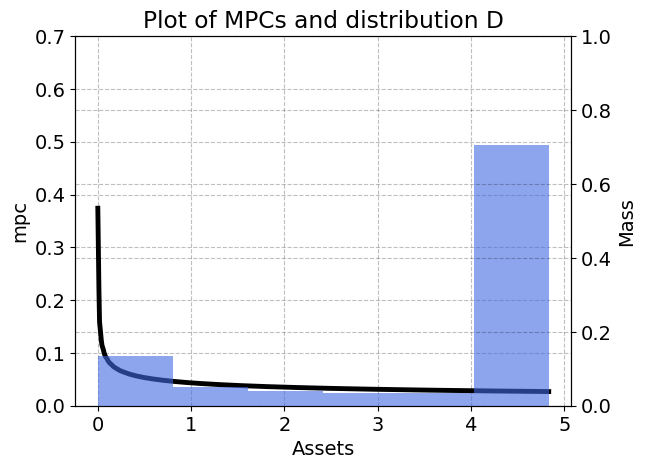

In [21]:
def mpc_plot(model):

    # mpc 
    mpc = get_mpcs(model, do_print=False)[0]

    # unload 
    par = model.par 
    D = model.sim.D 
    z_ergodic = par.z_ergodic
    a_grid = par.a_grid
    mpc_a = np.sum(mpc*z_ergodic[None,:,None], axis=(0,1))  # average over income in order to plot over assets only 
    D_a = np.sum(D, axis=(0,1))

    # plot settings for histogram 
    a_max = 5. # max a to plot 
    N_bins = 6 # number of bins to plot for histogram 
    i_a_max = np.searchsorted(a_grid, a_max) - 1

    # bin distribution for better plot 
    from scipy.stats import binned_statistic
    D_A_binned, bin_edges, binnumber = binned_statistic(a_grid[:i_a_max], D_a[:i_a_max], statistic='sum', bins=N_bins)
    D_A_binned[-1] += np.sum(D_a[i_a_max:]) # add all mass above a_max to top bin 
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 # get bin centers for plot 

    # Plot 
    fig, ax1 = plt.subplots()   

    # Plot mpc
    ax1.plot(a_grid[:i_a_max], mpc_a[:i_a_max], color='black', label='mpc', linewidth=3.5)
    ax1.set_xlabel('Assets')
    ax1.set_ylabel('mpc')
    ax1.tick_params(axis='y')
    ax1.set_ylim([0.,0.7])

    # Create a second y-axis for the histogram
    ax2 = ax1.twinx()
    ax2.bar(bin_centers, D_A_binned, width=bin_edges[1] - bin_edges[0], color='royalblue', alpha=0.6, label="Distribution")
    ax2.set_ylabel('Mass')
    ax2.tick_params(axis='y')
    ax2.set_ylim([0.,1.])

    plt.title("Plot of MPCs and distribution D")
    plt.show()

mpc_plot(model)

Calibrate model with low level of liquidity 

In [22]:
model_low_wealth = model.copy()
target_low_wealth = 0.5 * 4

sol = opt.root_scalar(calibrate_agg_wealth, bracket=[0.95, 0.989], method='brentq', args=(model_low_wealth, target_low_wealth))

Aggregate MPC 

In [23]:
_,_ = get_mpcs(model_low_wealth, do_print=True)

mean MPC:  0.342


plot mpcs 

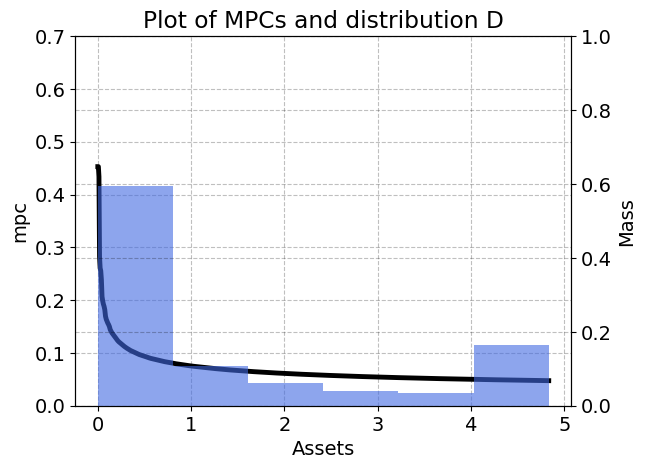

In [24]:
mpc_plot(model_low_wealth)

## 3. <a id='toc3_'></a>[Het-$\beta$ model](#toc0_)

Modify the household problem to allow for different discount factors across the population. In particular, the model is given by:
\begin{aligned}V\left(a_{t-1},z_{t},\beta'\right)= & \max_{c_{t}}u\left(c_{t}\right)+\beta'\mathbb{E}\left[V\left(a_{t},z_{t+1},\beta'\right)\right]\\
 & \text{ subject to }\\
 & c_{t}+a_{t}\leq a_{t-1}\left(1+r\right)+z_{t}\\
 & a_{t}\geq\underline{a}
\end{aligned}
where $\beta$ comes from an evenly spaced grid with $N_\beta$ points between $\beta-2\Delta,\beta+2\Delta$. 
Calibrate the model to match both a high level of liquidity and a high aggregate MPC using $(\beta, \Delta)$.

Note: You will need to update the code to set the beta grid (see next cell), and update the household problem appropriately.

In [89]:
model_hetbeta = ConSavModelClass()
model_hetbeta.par.Nbeta = 3 # Number of beta grid points 
model_hetbeta.allocate() # update size of beta grid 
model_hetbeta.par.beta_grid[:] = 0.97 # Values in grid 

In [90]:
model_hetbeta.solve(do_print=True)

iteration    0 solved in 2.1 secs   [max abs. diff. 1.47e+02]
iteration    1 solved in 0.0 secs   [max abs. diff. 4.93e+01]
iteration    2 solved in 0.0 secs   [max abs. diff. 2.47e+01]
iteration    3 solved in 0.0 secs   [max abs. diff. 1.49e+01]
iteration    4 solved in 0.0 secs   [max abs. diff. 9.91e+00]
iteration    5 solved in 0.0 secs   [max abs. diff. 7.08e+00]
iteration    6 solved in 0.0 secs   [max abs. diff. 5.31e+00]
iteration    7 solved in 0.0 secs   [max abs. diff. 4.13e+00]
iteration    8 solved in 0.0 secs   [max abs. diff. 3.31e+00]
iteration    9 solved in 0.0 secs   [max abs. diff. 2.70e+00]
iteration  100 solved in 0.0 secs   [max abs. diff. 7.72e-03]
iteration  200 solved in 0.0 secs   [max abs. diff. 2.20e-07]
iteration  231 solved in 0.0 secs   [max abs. diff. 9.30e-09]
model solved in 2.2 secs


In [91]:
model_hetbeta.simulate(do_print=True)

model prepared for simulation in 0.0 secs
model simulated in 3.5 secs [174 iterations]


Check the distribution 

In [92]:
print('Mass of distribution (should be 1):', np.sum(model_hetbeta.sim.D))
assert np.isclose(np.sum(model_hetbeta.sim.D), 1.0 )

Mass of distribution (should be 1): 0.9999999983181851


Check how many households are in the beta states. If the distribution is uniform it should have an equal number of households across the beta grid

In [93]:
beta_mass = np.sum(model_hetbeta.sim.D,axis=(1,2)).round(2)
print(f'Mass of households across beta grid: {beta_mass}')
print(f'Should be {1/model_hetbeta.par.Nbeta}')

Mass of households across beta grid: [0.33 0.33 0.33]
Should be 0.3333333333333333


Next, calibrate the model to both feature a high MPC and a high level of wealth

In [94]:
def calibrate_wealth_MPC(x, model, wealth_to_income_target, MPC_target, do_print):
    
    # a. guess on beta 
    mean_beta, Delta = x
    
    model.par.beta_grid[:] = np.linspace(mean_beta-2*Delta, mean_beta+2*Delta, model.par.Nbeta)
    # print(model.par.beta_grid)

    # b. solve
    model.solve(do_print=False)

    # c. simulate
    model.simulate(do_print=False)

    # d. aggregate 
    A = np.sum(model.sim.D*model.sol.a)

    # e. MPC
    MPC = get_mpcs(model, do_print=False)[1]

    if do_print: print('residual: ' f'{wealth_to_income_target - A:6.3f} {MPC - MPC_target:6.3f}')
   
    return np.array([wealth_to_income_target - A/model.par.w, MPC - MPC_target]) 

In [95]:
target_high_wealth = 4.1 * 4 # wealth target
MPC_target = 0.3 # MPC target 
x0 = np.array([0.9798, 0.0044]) # initial guess

sol = opt.root(calibrate_wealth_MPC, x0, method='hybr', args=(model_hetbeta, target_high_wealth, MPC_target, False))
assert sol.success

Check MPC

In [96]:
_ = get_mpcs(model_hetbeta, do_print=True)

mean MPC:  0.300


Plot MPCs  

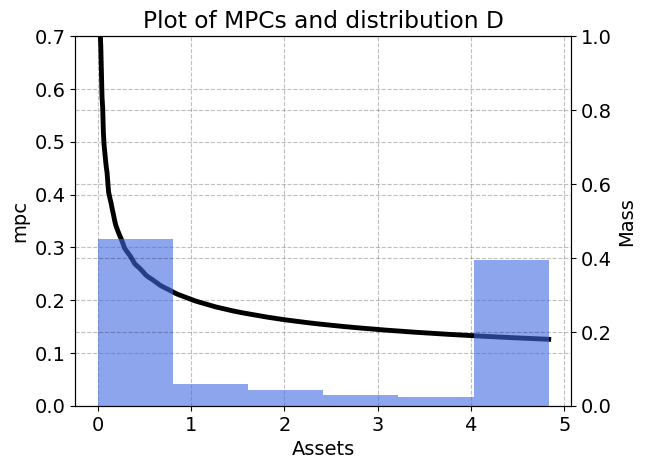

In [97]:
mpc_plot(model_hetbeta)

*Final question*. Try changing the mass of agents across the beta distribution. Set Nbeta=3 and assume that the mass is distributed as [0.2, 0.6, 0.2] across the beta grid. What part of the code do you have to modify?

*Answer*. We need to change the initial distribution sim.Dbeg_, which is normally set in the function "prepare_simulate" 

In [103]:
model_hetbeta.sim.Dbeg_[:] = 0. # initialize distribution at 0
model_hetbeta.sim.Dbeg_[0,:,0] = model_hetbeta.par.z_ergodic[None,:] * 0.2 # mass with beta_grid[0] 
model_hetbeta.sim.Dbeg_[1,:,0] = model_hetbeta.par.z_ergodic[None,:] * 0.6 # mass with beta_grid[1] 
model_hetbeta.sim.Dbeg_[2,:,0] = model_hetbeta.par.z_ergodic[None,:] * 0.2 # mass with beta_grid[2] 
assert np.isclose(np.sum(model_hetbeta.sim.Dbeg_), 1.0)

Simulate and check mass of households 

In [104]:
model_hetbeta.simulate(do_print=True, do_prepare=False)
beta_mass = np.sum(model_hetbeta.sim.D,axis=(1,2)).round(2)
print(f'Mass of households across beta grid: {beta_mass}')

model simulated in 2.1 secs [2240 iterations]
Mass of households across beta grid: [0.2 0.6 0.2]
